<a href="https://colab.research.google.com/github/vndee/pytorch-vi/blob/master/data_loading_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

#Data Loading and Processing Tutorial

**Author**: Sasank Chilamkurthy <https://chsasank.github.io>_

Một trong những vấn đề được đầu tư và bỏ công sức lớn trong việc giải quyết các bài toán học sâu đó là chuẩn bị dữ liệu. Do đó PyTorch cung cấp rất nhiều công cụ hỗ trợ cho việc load dữ liệu cũng xử lí dữ liệu một cách dễ dàng và trực quan. Trong bài này chúng ta sẽ tìm hiểu load và xử lý dữ liệu trong PyTorch thực sự hoạt động như thế nào.

Trước hết chúng ta cần cài một số package liên quan đến dữ liệu:
- `scikit-images`: Dùng để đọc và biến đổi ảnh.
- `pandas`:  Dùng để đọc file csv một cách dễ dàng.


In [0]:
import os
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from __future__ import print_function, division

# ignore warning
import warnings
warnings.filterwarnings('ignore')

# iteractive mode
plt.ion()

Chúng ta sẽ thử với một tập data `facial pose` tại địa chỉ: `<https://download.pytorch.org/tutorial/faces.zip>`. Tập data này được tạo từ `dlib's pose estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>` với một vài ảnh được gán nhãn "face" từ imagenet.
![alt text](https://pytorch.org/tutorials/_images/landmarked_face2.png)

In [0]:
!wget https://download.pytorch.org/tutorial/faces.zip && unzip faces.zip

Tập dữ liệu gồm vài tấm ảnh và một file csv với cấu trúc:
```
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312
```
Dữ liệu kiểu này có thể dễ dàng đọc được bằng pandas. Chúng ta sử dụng pandas để đọc dữ liệu vào một mảng (N, 2) với N là số lượng landmark.

In [5]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


Bây giờ chúng ta có thể viết một hàm đơn giản để hiển thị một vài ảnh cùng với landmark của nó để xem dữ liệu thực sự như thế nào.

In [0]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

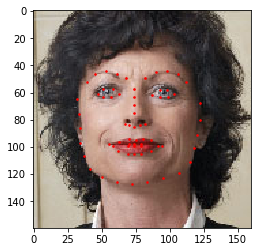

In [8]:
plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

## Lớp Dataset
`torch.utils.data.Dataset` là một abstract class thể hiện tập dữ liệu của PyTorch. Tất cả các tập dữ liệu của chúng ta nên kế thừa lớp này và override các phương thức sau:
- `__len__`: kích thước tập dữ liệu.
- `__getitem__`: dùng để truy xuất dữ liệu theo index như kiểu dữ liệu danh sách (ví dụ `dataset[i]`.

Chúng ta sẽ tạo một lớp `FaceLandmarksDataset` để lưu tập dữ liệu như đã nói đến ở trên. `FaceLandmarksDataset` sẽ đọc dữ liệu từ file csv. `FaceLandmarkDataset` sẽ được truyền vào tham số là đường dẫn đến file csv ở phương thức `__init__`, tuy nhiên việc đọc từng ảnh lên sẽ nằm ở phương thức `__getitem__`. Việc này sẽ giúp chương trình tiết kiệm bộ nhớ khá nhiều, trong rất nhiều chương trình huấn luyện các thuật toán học sâu, việc đọc lên một lần hết toàn bộ tập dữ liệu là một việc không nên. 

In [0]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample